# Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import dataset

In [7]:
df = pd.read_csv("Google_Stock_Price_Train.csv")

In [8]:
training_set = df.iloc[:, 1:2].values # Only Opening price

In [9]:
df.shape

(1258, 6)

In [10]:
training_set.shape

(1258, 1)

# Feature Scaling
For RNN we prefer to use MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(training_set)

In [12]:
training_set[:5]

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

In [13]:
train_set_scaled[:5]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225]])

### Create a data structure with 60 timestpes and 1 output
That is, it'll train on 60 stockprice values and predict the next one.

In [14]:
X_train = []
y_train = []
max = train_set_scaled.shape[0]
for i in range(60, max):
    X_train.append(train_set_scaled[i - 60:i, 0])
    y_train.append(train_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1198, 60), (1198,))

# Reshaping
RNN layer in keras has inputs: A 3D tensor, with shape `[batch, timesteps, feature]`

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

# Building the RNN

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
regressor = Sequential()
# First LSTM layer
# we are using stacked LSTM so we'll set return_sequence = True
# For inout shape we'll only provide timesteps and features
regressor.add(LSTM(units=50, return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

In [19]:
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))

In [20]:
# Output Layer
regressor.add(Dense(units=1))

In [21]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Training the model

In [22]:
regressor.fit(X_train, y_train, epochs=100,
              batch_size=32)

Epoch 1/100
38/38 [==============================] - 26s 138ms/step - loss: 0.0955
Epoch 2/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0067
Epoch 3/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0061
Epoch 4/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0062
Epoch 5/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0050
Epoch 6/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0047
Epoch 7/100
38/38 [==============================] - 5s 129ms/step - loss: 0.0049
Epoch 8/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0043
Epoch 9/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 5s 138ms/step - loss: 0.0047
Epoch 11/100
38/38 [==============================] - 5s 136ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 5s 139ms/step - loss: 0.0039
Epoch 13/100

38/38 [==============================] - 5s 132ms/step - loss: 0.0015
Epoch 100/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0015


In [25]:
df_test = pd.read_csv("Google_Stock_Price_Test.csv")
real_stock_price = df_test.iloc[:, 1:2].values
real_stock_price.shape

(20, 1)

## Predicting the stock price of January 2017

In [29]:
dataset_total = pd.concat((df['Open'], df_test['Open']), axis=0)
dataset_total.shape                            

(1278,)

In [31]:
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values

In [32]:
inputs = inputs.reshape(-1, 1)

In [33]:
inputs = sc.transform(inputs)

In [34]:
inputs.shape

(80, 1)

In [35]:
X_test = []
max = inputs.shape[0]
for i in range(60, max):
    X_test.append(inputs[i - 60:i, 0])
X_test = np.array(X_test)
X_test.shape

(20, 60)

In [36]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

In [37]:
predicted_stock_price = regressor.predict(X_test)

In [38]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [39]:
predicted_stock_price[:5]

array([[794.5762 ],
       [791.4896 ],
       [791.6784 ],
       [792.92126],
       [796.1928 ]], dtype=float32)

# Visualizing the results

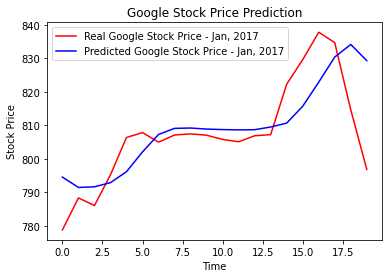

In [40]:
%matplotlib inline
plt.plot(real_stock_price, color='red', label='Real Google Stock Price - Jan, 2017')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price - Jan, 2017')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### RMSE

In [43]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

11.138035577630209